In [1]:
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
A = pd.read_csv("../assets/data/data_A.csv", header=None)
B = pd.read_csv("../assets/data/data_B.csv", header=None)
C = pd.read_csv("../assets/data/data_C.csv", header=None)

In [7]:
def stat_summary(X, iqrl=0.25, iqrr=0.75):
    '''
    Return for each timestamp (hr) return min, max, 0.25 quantile, 0.75 quantile, mean, var
    '''
    return pd.DataFrame(np.array([np.min(X, axis=0), np.quantile(X, axis=0, q=iqrl), np.median(X, axis=0), 
          np.quantile(X, axis=0, q=iqrr), np.max(X, axis=0), np.mean(X, axis=0), np.var(X, axis=0), np.std(X, axis=0)]).transpose(),
                        columns=["Min", "0.25Q", "Med", "0.75Q", "Max", "Mean", "Var", "StD"])

def trend(X, span = None):
    '''
    Return EWMA trend for signal samples
    '''
    if not span:
        span = X.shape[1]
    return pd.DataFrame(X).apply(lambda x: x.ewm(span=span).mean(), axis=1)

def train_test_val_split(X, y=None, test_size=0.2,  val_size=0.4):
    from sklearn.model_selection import train_test_split
    if y and y.__len__() > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size)
        return X_train, X_test, X_val, y_train, y_test, y_val
    else:
        X_train, X_test = train_test_split(X, test_size=test_size)
        X_test, X_val = train_test_split(X_test, test_size=val_size)
        return X_train, X_test, X_val

def reshapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(-1,1))
    return np.array(X_)

def shapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(1,-1)[0])
    return np.array(X_)


def meanShift(X, window=None):
    '''
    Apply MA on convolved signal and compute rs means
    '''
    # At this point X must be EWMA convolved already
    if not window:
        window = X.shape[1] // 2
    return pd.DataFrame(X).apply(lambda x: x.rolling(window=window).mean(), axis=1).iloc[:,window-1:]

def gradient(X, shift=1, threshold=0):
    '''
    First order gradient of signal. Eq to diff for discrete signal
    '''
    return pd.DataFrame(X).apply(lambda x: x.diff(periods=shift), axis=1).iloc[:,threshold:]

def bucketPeaks(peakIndex):
    '''
    Bucket into first half and second half
    '''
    return(sum(peakIndex <= 12), sum(peakIndex > 12)) 

<b> Here the key task will be to examine and discriminate ABC tool signals</b>

Lets take small random samples and check aggregates

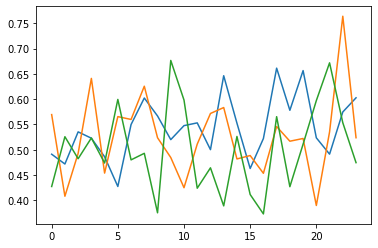

In [56]:
idx_1 = np.random.randint(0, min(A.__len__(), B.__len__(), C.__len__()) // 1.2, 1)[0]
idx_2 = np.random.randint(idx_1, min(A.__len__(), B.__len__(), C.__len__()), 1)[0]
plt.plot(stat_summary(A.values[idx_1:idx_2]).iloc[:,5], label="A")
plt.plot(stat_summary(B.values[idx_1:idx_2]).iloc[:,5], label="B")
plt.plot(stat_summary(C.values[idx_1:idx_2]).iloc[:,5], label="C")
plt.show()

Re-running the above cell shows significant contamination for Tools A & B which get confounded with C.<br/>
An example is to set (idx_1, idx_2) := (1872, 1885) and run it

<b> Data - Cleaning </b>

<u>Hypothesis</u>: Tool C is minimally contaminated, so we use C patterns to filter out outliers from A and B<br/>
<u>Support</u>: Below plots for tools shows skewed distributions of trends for A and B, which may be attributed to outliers

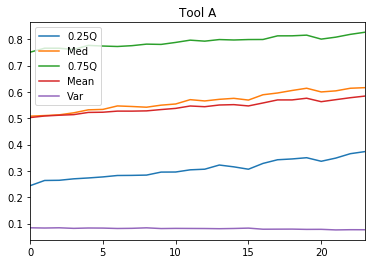

In [62]:
stat_summary(A.values).iloc[:,[1,2,3,5,6]].plot()
plt.title("Tool A")
plt.show()

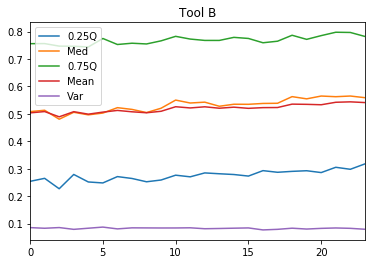

In [61]:
stat_summary(B.values).iloc[:,[1,2,3,5,6]].plot()
plt.title("Tool B")
plt.show()

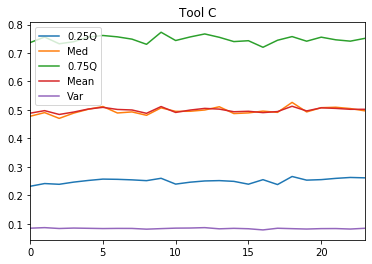

In [63]:
stat_summary(C.values).iloc[:,[1,2,3,5,6]].plot()
plt.title("Tool C")
plt.show()

<b><u>1. LSTM Autoencoder on C:</u></b>

In [4]:
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [5]:
timesteps = 24
input_dim = 1 
latent_dim = 1

inputs = tf.keras.Input(shape=(timesteps, input_dim))
encoded = tf.keras.layers.LSTM(latent_dim)(inputs)

decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
decoded = tf.keras.layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder = tf.keras.Model(inputs, decoded)
encoder = tf.keras.Model(inputs, encoded)

In [8]:
X_train, X_test, X_val = train_test_val_split(C.values, test_size=0.1)
# X_train, X_test, X_val = train_test_val_split(trend(C.values).values, test_size=0.1)

In [9]:
X_train.shape

(2089, 24)

In [10]:
sequence_autoencoder.compile(loss="mae", metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
sequence_autoencoder.fit(reshapeInput(X_train), reshapeInput(X_train), batch_size=50, epochs=500, 
                         validation_data=(reshapeInput(X_val), reshapeInput(X_val)), 
                         callbacks=tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True))

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
42/42 [==============================] - ETA: 0s - loss: 0.5322 - mse: 0.3671WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001770CBB6678> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

42/42 [==============================] - 0s 11ms/step - loss: 0.2495 - mse: 0.0832 - val_loss: 0.2530 - val_mse: 0.0848
Epoch 110/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2493 - mse: 0.0831 - val_loss: 0.2530 - val_mse: 0.0849
Epoch 111/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2493 - mse: 0.0832 - val_loss: 0.2530 - val_mse: 0.0849A: 0s - loss: 0.2496 - mse: 
Epoch 112/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2504 - mse: 0.0837 - val_loss: 0.2530 - val_mse: 0.0848
Epoch 113/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2501 - mse: 0.0836 - val_loss: 0.2530 - val_mse: 0.0848
Epoch 114/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2496 - mse: 0.0833 - val_loss: 0.2530 - val_mse: 0.0848
Epoch 115/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2495 - mse: 0.0832 - val_loss: 0.2530 - val_mse: 0.0848
Epoch 116/500
42/42 [===========================

42/42 [==============================] - 0s 11ms/step - loss: 0.2500 - mse: 0.0834 - val_loss: 0.2528 - val_mse: 0.0847
Epoch 171/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2495 - mse: 0.0832 - val_loss: 0.2528 - val_mse: 0.0847
Epoch 172/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2493 - mse: 0.0830 - val_loss: 0.2528 - val_mse: 0.0847
Epoch 173/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2492 - mse: 0.0829 - val_loss: 0.2528 - val_mse: 0.0847
Epoch 174/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2497 - mse: 0.0834 - val_loss: 0.2528 - val_mse: 0.0847
Epoch 175/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2500 - mse: 0.0833 - val_loss: 0.2528 - val_mse: 0.0847
Epoch 176/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2496 - mse: 0.0833 - val_loss: 0.2528 - val_mse: 0.0847
Epoch 177/500
42/42 [==============================] - 0s 11ms/step - loss: 

42/42 [==============================] - 0s 11ms/step - loss: 0.2488 - mse: 0.0829 - val_loss: 0.2527 - val_mse: 0.0846
Epoch 293/500
42/42 [==============================] - 0s 10ms/step - loss: 0.2492 - mse: 0.0832 - val_loss: 0.2527 - val_mse: 0.0846
Epoch 294/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2497 - mse: 0.0833 - val_loss: 0.2527 - val_mse: 0.0846
Epoch 295/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2500 - mse: 0.0833 - val_loss: 0.2527 - val_mse: 0.0846
Epoch 296/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2481 - mse: 0.0824 - val_loss: 0.2527 - val_mse: 0.0846
Epoch 297/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2489 - mse: 0.0828 - val_loss: 0.2527 - val_mse: 0.0846
Epoch 298/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2493 - mse: 0.0830 - val_loss: 0.2527 - val_mse: 0.0846
Epoch 299/500
42/42 [==============================] - 0s 11ms/step - loss: 

42/42 [==============================] - 1s 13ms/step - loss: 0.2434 - mse: 0.0805 - val_loss: 0.2472 - val_mse: 0.0827
Epoch 415/500
42/42 [==============================] - 1s 13ms/step - loss: 0.2439 - mse: 0.0808 - val_loss: 0.2471 - val_mse: 0.0828
Epoch 416/500
42/42 [==============================] - 1s 13ms/step - loss: 0.2444 - mse: 0.0809 - val_loss: 0.2472 - val_mse: 0.0827
Epoch 417/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2438 - mse: 0.0808 - val_loss: 0.2471 - val_mse: 0.0828
Epoch 418/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2439 - mse: 0.0807 - val_loss: 0.2471 - val_mse: 0.0827
Epoch 419/500
42/42 [==============================] - 0s 11ms/step - loss: 0.2441 - mse: 0.0810 - val_loss: 0.2472 - val_mse: 0.0827
Epoch 420/500
42/42 [==============================] - 0s 12ms/step - loss: 0.2440 - mse: 0.0810 - val_loss: 0.2472 - val_mse: 0.0827
Epoch 421/500
42/42 [==============================] - 0s 11ms/step - loss: 

Lets try the autoencoder reconstruction errors on random samples from A, B and C

In [11]:
def reconstruct(autoencoder, sample):
    #return shapeInput(sequence_autoencoder.predict(reshapeInput(trend(sample).values.reshape(1,-1))))[0]
    return shapeInput(sequence_autoencoder.predict(reshapeInput(sample.reshape(1,-1))))[0]

rand_idx = np.random.randint(0, min(A.__len__(), B.__len__(), C.__len__()), 1)[0]
print(f"For A: {mean_absolute_error(trend(A.values[rand_idx].reshape(1,-1)).values[0], reconstruct(sequence_autoencoder, A.values[rand_idx].reshape(1,-1)))} \
      \nFor B: {mean_absolute_error(trend(B.values[rand_idx].reshape(1,-1)).values[0], reconstruct(sequence_autoencoder, B.values[rand_idx].reshape(1,-1)))} \
      \nFor C: {mean_absolute_error(trend(C.values[rand_idx].reshape(1,-1)).values[0], reconstruct(sequence_autoencoder, C.values[rand_idx].reshape(1,-1)))}")


In [57]:
rand_idx = np.random.randint(0, min(A.__len__(), B.__len__(), C.__len__()), 1)[0]
print(f"For A: {mean_absolute_error(A.values[rand_idx], reconstruct(sequence_autoencoder, A.values[rand_idx].reshape(1,-1)))} \
      \nFor B: {mean_absolute_error(B.values[rand_idx], reconstruct(sequence_autoencoder, B.values[rand_idx].reshape(1,-1)))} \
      \nFor C: {mean_absolute_error(C.values[rand_idx], reconstruct(sequence_autoencoder, C.values[rand_idx].reshape(1,-1)))}")


For A: 0.24258993759377412       
For B: 0.2879475770673078       
For C: 0.21438172083453366


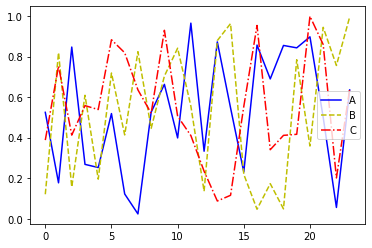

In [58]:
plt.plot(A.values[rand_idx], 'b-',label="A")
plt.plot(B.values[rand_idx], 'y--',label="B")
plt.plot(C.values[rand_idx], 'r-.', label="C")
plt.legend()
plt.show()

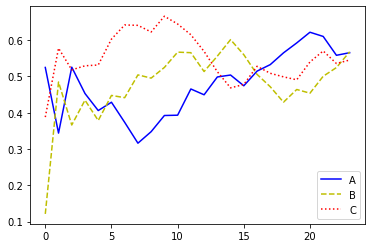

In [59]:
plt.plot(trend(A.values[rand_idx].reshape(1,-1)).values[0], 'b-',label="A")
plt.plot(trend(B.values[rand_idx].reshape(1,-1)).values[0], 'y--',label="B")
plt.plot(trend(C.values[rand_idx].reshape(1,-1)).values[0], 'r:', label="C")
plt.legend()
plt.show()

<b>The autoencoder learns the signal pattern for trend of Tool C signals, which remains more or less constant as we saw in the mean shift exercise</b><br/>
So signals from any tool that behave with constant trend are easier to reconstruct in general, with lower error<br/>
Re-run above cells to verify this

<u>Clean Data:</u>

In [60]:
def clean(X, autoencoder_C, threshold_mae = 0.2):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    results = autoencoder_C.predict(reshapeInput(X.values))
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors > threshold_mae)]

def clean_self(X, autoencoder_C, threshold_mae = 0.2):
    '''
    Uses recontruction errors (> threshold) to clean Tool A and Tool B signals
    '''
    #results = autoencoder_C.predict(reshapeInput(trend(X.values).values))
    results = autoencoder_C.predict(reshapeInput(X.values))
    #errors = mean_absolute_error(trend(X.values).values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    errors = mean_absolute_error(X.values.transpose(), shapeInput(results).transpose(), multioutput='raw_values')
    return X.values[(errors < threshold_mae)]

In [61]:
mean_absolute_error(C.values, shapeInput(sequence_autoencoder.predict(reshapeInput(C.values))))

0.2439255297721461

In [62]:
C_ = clean_self(C, sequence_autoencoder, threshold_mae=0.25)

In [63]:
C_.shape, C.shape

((1334, 24), (2322, 24))

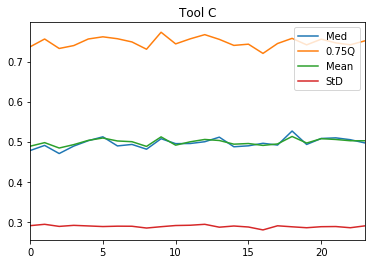

In [64]:
stat_summary(C.values).iloc[:,[2,3,5,7]].plot()
plt.title("Tool C")
plt.show()

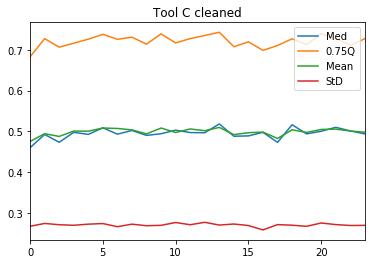

In [65]:
stat_summary(C_).iloc[:,[2,3,5,7]].plot()
plt.title("Tool C cleaned")
plt.show()

sequence_autoencoder.save("../assets/models/C_autoencoder_dirty")

The variance for tool C samples has been reduced

In [69]:
timesteps = 24
input_dim = 1 
latent_dim = 1

inputs = tf.keras.Input(shape=(timesteps, input_dim))
encoded = tf.keras.layers.LSTM(latent_dim)(inputs)

decoded = tf.keras.layers.RepeatVector(timesteps)(encoded)
decoded = tf.keras.layers.LSTM(input_dim, return_sequences=True)(decoded)

sequence_autoencoder_C = tf.keras.Model(inputs, decoded)

In [70]:
X_train, X_test, X_val = train_test_val_split(C_, test_size=0.05)
# X_train, X_test, X_val = train_test_val_split(trend(C.values).values, test_size=0.1)

In [71]:
X_train.shape, X_val.shape

((1267, 24), (27, 24))

In [72]:
sequence_autoencoder_C.compile(loss="mae", metrics=[tf.keras.metrics.MeanSquaredError(name='mse')])
sequence_autoencoder_C.fit(reshapeInput(X_train), reshapeInput(X_train), batch_size=50, epochs=500, 
                         validation_data=(reshapeInput(X_val), reshapeInput(X_val)), 
                         callbacks=tf.keras.callbacks.EarlyStopping(patience=500, restore_best_weights=True))

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - ETA: 0s - loss: 0.5489 - mse: 0.3762WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000179355EA9D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
26/26 [==============================] - 3s 32ms/step - loss: 0.5485 - mse: 0.3758 - val_loss: 0.5314 - val_mse: 0.3531
Epoch 2/500
26/26 [==============================] - 0s 12ms/step - loss: 0.5057 - mse: 0.3303 - val_loss: 0.4960 - val_mse: 0.3165
Epoch 3/500
26/26 [==============================] - 0s 12ms/step - loss: 0.4750 - mse: 0.2989 - val_loss: 0.4604 - val_mse: 0.2814
Epoch 4/500
26/26 [==============================] - 0s 11ms/step - loss: 0.4378 - mse: 0.2628 - val_loss: 0.4169 - val_mse: 0.2405
Epoch 5/500
26/26 [==============================] - 0s 12ms/step - loss: 0.3958 - mse: 0.2223 - val_loss: 0.3605 - val_mse: 0.1879
Epoch 6/500
26/26 [======================

26/26 [==============================] - 0s 12ms/step - loss: 0.2225 - mse: 0.0703 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 121/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2220 - mse: 0.0699 - val_loss: 0.2230 - val_mse: 0.0689
Epoch 122/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2221 - mse: 0.0701 - val_loss: 0.2235 - val_mse: 0.0693
Epoch 123/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2228 - mse: 0.0706 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 124/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2221 - mse: 0.0703 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 125/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2229 - mse: 0.0705 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 126/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2224 - mse: 0.0704 - val_loss: 0.2230 - val_mse: 0.0689
Epoch 127/500
26/26 [==============================] - 0s 11ms/step - loss: 

Epoch 242/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2221 - mse: 0.0702 - val_loss: 0.2230 - val_mse: 0.0689
Epoch 243/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2230 - mse: 0.0706 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 244/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2233 - mse: 0.0707 - val_loss: 0.2231 - val_mse: 0.0690
Epoch 245/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2225 - mse: 0.0703 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 246/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2226 - mse: 0.0705 - val_loss: 0.2231 - val_mse: 0.0690
Epoch 247/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2224 - mse: 0.0702 - val_loss: 0.2228 - val_mse: 0.0688
Epoch 248/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2230 - mse: 0.0705 - val_loss: 0.2232 - val_mse: 0.0691
Epoch 249/500
26/26 [==============================] - 0s 12ms

26/26 [==============================] - 0s 12ms/step - loss: 0.2223 - mse: 0.0703 - val_loss: 0.2232 - val_mse: 0.0691
Epoch 365/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2225 - mse: 0.0703 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 366/500
26/26 [==============================] - 0s 15ms/step - loss: 0.2219 - mse: 0.0700 - val_loss: 0.2231 - val_mse: 0.0689
Epoch 367/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2220 - mse: 0.0700 - val_loss: 0.2236 - val_mse: 0.0693
Epoch 368/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2235 - mse: 0.0708 - val_loss: 0.2231 - val_mse: 0.0690
Epoch 369/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2226 - mse: 0.0703 - val_loss: 0.2231 - val_mse: 0.0689
Epoch 370/500
26/26 [==============================] - 0s 11ms/step - loss: 0.2216 - mse: 0.0700 - val_loss: 0.2229 - val_mse: 0.0688
Epoch 371/500
26/26 [==============================] - 0s 12ms/step - loss: 

26/26 [==============================] - 0s 12ms/step - loss: 0.2226 - mse: 0.0703 - val_loss: 0.2243 - val_mse: 0.0701
Epoch 487/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2227 - mse: 0.0703 - val_loss: 0.2234 - val_mse: 0.0691
Epoch 488/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2215 - mse: 0.0697 - val_loss: 0.2231 - val_mse: 0.0689
Epoch 489/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2220 - mse: 0.0702 - val_loss: 0.2230 - val_mse: 0.0688
Epoch 490/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2218 - mse: 0.0699 - val_loss: 0.2230 - val_mse: 0.0688
Epoch 491/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2220 - mse: 0.0700 - val_loss: 0.2231 - val_mse: 0.0689
Epoch 492/500
26/26 [==============================] - 0s 12ms/step - loss: 0.2231 - mse: 0.0704 - val_loss: 0.2230 - val_mse: 0.0688
Epoch 493/500
26/26 [==============================] - 0s 12ms/step - loss: 

In [74]:
mean_absolute_error(C_, shapeInput(sequence_autoencoder_C.predict(reshapeInput(C_))))

0.2226188986326394

In [75]:
mean_absolute_error(A.values, shapeInput(sequence_autoencoder_C.predict(reshapeInput(A.values))))

0.24194904058013714

In [76]:
mean_absolute_error(B.values, shapeInput(sequence_autoencoder_C.predict(reshapeInput(B.values))))

0.24336966151550646

<b>Lets clean A and B now</b>

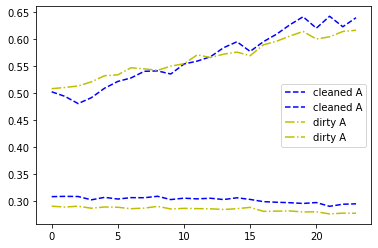

In [77]:
A_ = clean(A, sequence_autoencoder_C, 0.24)
plt.plot(stat_summary(A_).iloc[:,[2,7]], 'b--',label='cleaned A')
plt.plot(stat_summary(A).iloc[:,[2,7]], 'y-.',label='dirty A')
plt.legend()
plt.show()

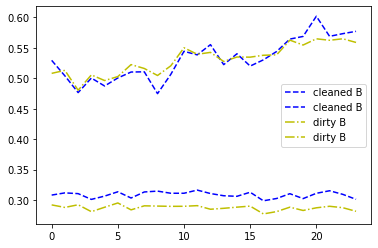

In [78]:
B_ = clean(B, sequence_autoencoder_C, 0.25)
plt.plot(stat_summary(B_).iloc[:,[2,7]], 'b--',label='cleaned B')
plt.plot(stat_summary(B).iloc[:,[2,7]], 'y-.',label='dirty B')
plt.legend()
plt.show()

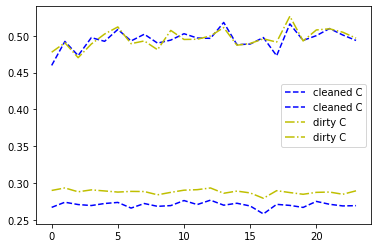

In [79]:
plt.plot(stat_summary(C_).iloc[:,[2,7]], 'b--',label='cleaned C')
plt.plot(stat_summary(C).iloc[:,[2,7]], 'y-.',label='dirty C')
plt.legend()
plt.show()

<b>1. As we can see, after cleaning, we can capture the trend better since many C signals that confounded B and A are now removed. <br/>2. Also increasing the variance we will now have more information to capture A & B.<br/>3. Also noteworthy is that we minimized the local variance in C which will help us segregate it from A & B </b>

sequence_autoencoder_C.save("../assets/models/C_autoencoder_final")

pd.DataFrame(C_).to_csv("../assets/data/cleaned/C.csv")

## Due to memory constraints refresh kernel at this point and proceed

In [1]:
import pandas as pd
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
A = pd.read_csv("../assets/data/cleaned/A.csv", index_col=0)
B = pd.read_csv("../assets/data/cleaned/B.csv", index_col=0)
C = pd.read_csv("../assets/data/cleaned/C.csv", index_col=0)

Looking at the cleaned dataset

In [3]:
B.shape, C.shape, A.shape

((1111, 24), (1334, 24), (2679, 24))

In [4]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [5]:
model_classif_ABC = tf.keras.Sequential()
model_classif_ABC.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True), input_shape=(24, 1)))
model_classif_ABC.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='relu')))
model_classif_ABC.add(tf.keras.layers.Flatten())
model_classif_ABC.add(tf.keras.layers.Dropout(0.2))
model_classif_ABC.add(tf.keras.layers.Dense(12, activation='relu'))
model_classif_ABC.add(tf.keras.layers.Dense(3, activation='sigmoid'))
model_classif_ABC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
def stat_summary(X, iqrl=0.25, iqrr=0.75):
    '''
    Return for each timestamp (hr) return min, max, 0.25 quantile, 0.75 quantile, mean, var
    '''
    return pd.DataFrame(np.array([np.min(X, axis=0), np.quantile(X, axis=0, q=iqrl), np.median(X, axis=0), 
          np.quantile(X, axis=0, q=iqrr), np.max(X, axis=0), np.mean(X, axis=0), np.var(X, axis=0), np.std(X, axis=0)]).transpose(),
                        columns=["Min", "0.25Q", "Med", "0.75Q", "Max", "Mean", "Var", "StD"])

def trend(X, span = None):
    '''
    Return EWMA trend for signal samples
    '''
    if not span:
        span = X.shape[1]
    return pd.DataFrame(X).apply(lambda x: x.ewm(span=span).mean(), axis=1)

def train_test_val_split(X, y=None, test_size=0.2,  val_size=0.4):
    from sklearn.model_selection import train_test_split
    if y.__len__() > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_size)
        return X_train, X_test, X_val, y_train, y_test, y_val
    else:
        X_train, X_test = train_test_split(X, test_size=test_size)
        X_test, X_val = train_test_split(X_test, test_size=val_size)
        return X_train, X_test, X_val

def reshapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(-1,1))
    return np.array(X_)

def shapeInput(X):
    X_ = []
    for x in X:
        X_.append(x.reshape(1,-1)[0])
    return np.array(X_)


def meanShift(X, window=None):
    '''
    Apply MA on convolved signal and compute rs means
    '''
    # At this point X must be EWMA convolved already
    if not window:
        window = X.shape[1] // 2
    return pd.DataFrame(X).apply(lambda x: x.rolling(window=window).mean(), axis=1).iloc[:,window-1:]

def gradient(X, shift=1, threshold=0):
    '''
    First order gradient of signal. Eq to diff for discrete signal
    '''
    return pd.DataFrame(X).apply(lambda x: x.diff(periods=shift), axis=1).iloc[:,threshold:]

def bucketPeaks(peakIndex):
    '''
    Bucket into first half and second half
    '''
    return(sum(peakIndex <= 12), sum(peakIndex > 12)) 

In [7]:
X = np.row_stack((A,B,C))
Y = [0]*(A.__len__()) + [1]*(B.__len__()) + [2]*C.__len__()

In [8]:
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X, tf.keras.utils.to_categorical(Y), test_size=0.1)

In [10]:
model_classif_ABC.fit(reshapeInput(X_train), y_train, 
          epochs=120, batch_size=100,
          validation_data=(reshapeInput(X_val), y_val),
         callbacks=tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True))

Epoch 1/120
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
42/47 [=========================>....] - ETA: 0s - loss: 1.0606 - accuracy: 0.5094WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024AE85428B8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

Epoch 45/120
47/47 [==============================] - 1s 11ms/step - loss: 0.7712 - accuracy: 0.6637 - val_loss: 0.8284 - val_accuracy: 0.6311
Epoch 46/120
47/47 [==============================] - 1s 11ms/step - loss: 0.7907 - accuracy: 0.6472 - val_loss: 0.8434 - val_accuracy: 0.5922
Epoch 47/120
47/47 [==============================] - 1s 12ms/step - loss: 0.7915 - accuracy: 0.6546 - val_loss: 0.8407 - val_accuracy: 0.6505
Epoch 48/120
47/47 [==============================] - 1s 12ms/step - loss: 0.7856 - accuracy: 0.6566 - val_loss: 0.8365 - val_accuracy: 0.6019
Epoch 49/120
47/47 [==============================] - 1s 12ms/step - loss: 0.7613 - accuracy: 0.6602 - val_loss: 0.8348 - val_accuracy: 0.6456
Epoch 50/120
47/47 [==============================] - 1s 12ms/step - loss: 0.7776 - accuracy: 0.6630 - val_loss: 0.8255 - val_accuracy: 0.6214
Epoch 51/120
47/47 [==============================] - 1s 12ms/step - loss: 0.7880 - accuracy: 0.6437 - val_loss: 0.8341 - val_accuracy: 0.6068

In [12]:
confusion_matrix(np.argmax(y_test, axis=1), model_classif_ABC.predict_classes(reshapeInput(X_test)))

C:\Users\sabri\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[131,  17,   5],
       [ 37,  19,   8],
       [  9,   2,  79]], dtype=int64)

<b> Some important highlights:</b>
1. When the dataset belong to B, we has a lot of confounding still with A. This shows that the A dataset is still unclean with polluted signals from B.
2. When the datapoint belong to C, there is no more confounding with A or B since we now cleaned the B and A datasets from C effects

<b> Lets test our hypothesis with just B vs C </b>

In [19]:
model_classif_BC = tf.keras.Sequential()
model_classif_BC.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True), input_shape=(24, 1)))
model_classif_BC.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='relu')))
model_classif_BC.add(tf.keras.layers.Flatten())
model_classif_BC.add(tf.keras.layers.Dropout(0.2))
model_classif_BC.add(tf.keras.layers.Dense(12, activation='relu'))
model_classif_BC.add(tf.keras.layers.Dense(2, activation='sigmoid'))
model_classif_BC.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
X = np.row_stack((B,C))
Y = [0]*(B.__len__()) + [1]*C.__len__()
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X, tf.keras.utils.to_categorical(Y), test_size=0.1)

In [21]:
model_classif_BC.fit(reshapeInput(X_train), y_train, 
          epochs=120, batch_size=100,
          validation_data=(reshapeInput(X_val), y_val),
         callbacks=tf.keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True))

Epoch 1/120
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/22 [========================>.....] - ETA: 0s - loss: 0.6926 - accuracy: 0.5415WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000024B234E1288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`)

Epoch 45/120
22/22 [==============================] - 0s 10ms/step - loss: 0.4015 - accuracy: 0.8215 - val_loss: 0.4229 - val_accuracy: 0.8571
Epoch 46/120
22/22 [==============================] - 0s 10ms/step - loss: 0.4218 - accuracy: 0.8068 - val_loss: 0.4989 - val_accuracy: 0.7143
Epoch 47/120
22/22 [==============================] - 0s 11ms/step - loss: 0.3911 - accuracy: 0.8243 - val_loss: 0.4049 - val_accuracy: 0.8776
Epoch 48/120
22/22 [==============================] - 0s 11ms/step - loss: 0.3528 - accuracy: 0.8588 - val_loss: 0.3811 - val_accuracy: 0.8367
Epoch 49/120
22/22 [==============================] - 0s 11ms/step - loss: 0.3829 - accuracy: 0.8297 - val_loss: 0.3806 - val_accuracy: 0.8571
Epoch 50/120
22/22 [==============================] - 0s 11ms/step - loss: 0.3466 - accuracy: 0.8544 - val_loss: 0.3814 - val_accuracy: 0.8571
Epoch 51/120
22/22 [==============================] - 0s 11ms/step - loss: 0.3591 - accuracy: 0.8483 - val_loss: 0.3658 - val_accuracy: 0.8367

In [24]:
confusion_matrix(np.argmax(y_test, axis=1), model_classif_BC.predict_classes(reshapeInput(X_test)))

C:\Users\sabri\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[62,  4],
       [11, 70]], dtype=int64)

## Perfect: So we are in the right track, with the cleaned data, we can now segregate B vs C; <br/>Next, we need to de-noise data_A from B signals